# Bot Step 2

### Import packages

In [1]:
import json
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import pickle
import prince
import os

## Load in data

### All distinct accounts

In [2]:
def read_author_data():
    """ Function that reads the 'accounts.pkl' file and prints some descriptive stats.
    """
    with open('accounts.pkl', 'rb') as f:
        author_data = pickle.load(f)
    
    print('We have {} accounts, for which we have user name, id, and screen name.'.format(len(author_data)))
    print('Example: {}'.format(author_data[0]))
    
    return author_data

In [3]:
author_data = read_author_data()

We have 5876 accounts, for which we have user name, id, and screen name.
Example: ('RepFredUpton', '124224165', 'Rep. Fred Upton')


### Followers for (a selection of) these accounts

In [4]:
def read_account_data():
    """ Function that reads in the account data and returns this data in a dictionary.
    """
    account_data = dict()
    os.chdir(os.getcwd() + '\\following_lists')
    
    for filename in os.listdir(os.getcwd()):
        id = filename.split('_')[0]
        with open(filename, 'rb') as f:
            account_data[id] = pickle.load(f)

    os.chdir('..')
    
    return account_data

In [5]:
account_data = read_account_data()

## Create Adjacency Matrix

In [6]:
def create_adjacency_matrix(type='undirected'):
    """ Function that creates an adjacency matrix with the respective type.
    """
    adj_df = pd.DataFrame(0, index=[author_data[i][1] for i in range(len(author_data))],
                      columns=[author_data[i][1] for i in range(len(author_data))])
    col_set = {author_data[i][1] for i in range(len(author_data))}
    
    i = 0
    for key in account_data.keys():
        fol_list = list(account_data[key])
        fol_set = {fol_list[i][1] for i in range(len(fol_list))}
        for id_ in fol_set:
            if id_ in col_set:
                adj_df[id_].loc[key] = 1
                if (type=='undirected'):
                    adj_df[key].loc[id_] = 1

        i += 1
        if (i % 100 == 0):
            print(i)
    
    return adj_df

In [7]:
adj_df = create_adjacency_matrix(type='undirected')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


## Check whether we have zero columns and/or rows

In [8]:
def remove_null(adj_df):
    """ Function that removes null rows/columns from the adjacency matrix. These
        nulls correspond with authors that do not follow anyone and are not followed
        by anyone of interest.
    """
    zero_follower = 0
    drop_idx_list = []
    for i in range(len(adj_df)):
        if np.sum(adj_df.iloc[i,:]) == 0:
            zero_follower += 1
            drop_idx_list.append(adj_df.columns[i])
    
    print('The number of entries we delete is {}.'.format(zero_follower))
    adj_df_nz = adj_df.copy()
    adj_df_nz = adj_df_nz.drop(drop_idx_list, axis=0)
    adj_df_nz = adj_df_nz.drop(drop_idx_list, axis=1)
    
    return adj_df_nz

In [9]:
adj_df_nz = remove_null(adj_df)

The number of entries we delete is 76.


In [10]:
def write_to_file(filename, adj_df_nz):
    """ Write the adjacency matrix dataframe to a csv file.
    """
    adj_df_nz.to_csv(filename)
    return

In [11]:
write_to_file('adj_matrix.csv', adj_df_nz)

All columns that are purely 0 have corresponding rows that are 0 too. I.e., if someone was not followed by anyone in our data, this person did not follow anyone either. 

## Correspondence Analysis

In [12]:
def corresp_analysis(filename = '0'):
    df = pd.read_csv(filename, index_col=0)
    
    ca = prince.CA(n_components=100, n_iter=100)
    ca.fit(df)
    
    print('The first PC explains around {}% of variance.'.format(100*ca.eigenvalues_[0]/sum(ca.eigenvalues_)))
    
    pca_vals = ca.row_coordinates(df) # One can check that column PCA projs are exactly equal
    scores = pca_vals.iloc[:,0]
    
    return scores

In [13]:
ideology_scores = corresp_analysis(filename='adj_matrix.csv')

The first PC explains around 11.32605157511833% of variance.


#### Use scores to form quantiles

In [14]:
ideology_scores

124224165     0.844295
242926427     0.920977
234822928     1.275552
12788332      0.888146
52503751      1.109054
                ...   
325581008     0.113305
305818748    -0.672569
3021632183    0.216137
16796658     -0.051347
301628954     0.017839
Name: 0, Length: 5800, dtype: float64

In [15]:
def create_quantiles(scores):
    """ Function that maps a series of ideology scores into 7 quantiles.
    """
    q1_val = ideology_scores.quantile(1/7)
    q2_val = ideology_scores.quantile(2/7)
    q3_val = ideology_scores.quantile(3/7)
    q4_val = ideology_scores.quantile(4/7)
    q5_val = ideology_scores.quantile(5/7)
    q6_val = ideology_scores.quantile(6/7)
    
    mapping_dict = dict()
    
    for author_id in list(scores.index):
        score = scores.loc[author_id]
        quantile = 0
        if score < q1_val:
            quantile = 1
        elif score < q2_val:
            quantile = 2
        elif score < q3_val:
            quantile = 3
        elif score < q4_val:
            quantile = 4
        elif score < q5_val:
            quantile = 5
        elif score < q6_val:
            quantile = 6
        else:
            quantile = 7
        
        mapping_dict[author_id] = {'score': score, 'quantile': quantile}
    
    return mapping_dict

In [16]:
score_mapping = create_quantiles(ideology_scores)

In [17]:
with open('score_mappings.json', 'w') as f:
    json.dump(score_mapping, f)

## Create PCA Graph

In [18]:
import seaborn

In [19]:
scores = [score_mapping[id_]['score'] for id_ in score_mapping.keys()]
colors = [score_mapping[id_]['quantile'] for id_ in score_mapping.keys()]

In [20]:
colors = np.array(colors)
scores = np.array(scores)

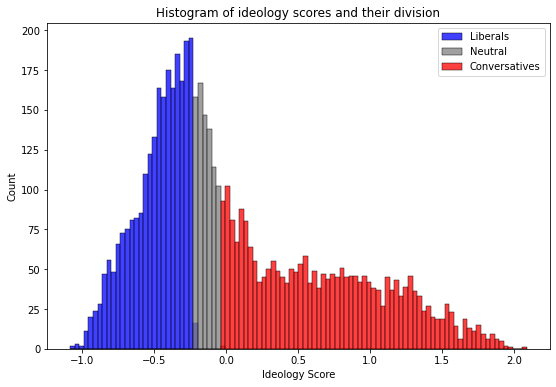

In [21]:
plt.figure(figsize=(9,6))
palette_ = seaborn.color_palette('Reds')
seaborn.histplot(scores[colors<4], binrange=(min(scores),max(scores)), bins=100, color='blue')
seaborn.histplot(scores[colors==4], binrange=(min(scores), max(scores)), bins=100, color='gray')
seaborn.histplot(scores[colors>4], binrange=(min(scores), max(scores)), bins=100, color='red')
plt.legend(['Liberals', 'Neutral', 'Conversatives'])
plt.xlabel('Ideology Score')
plt.title('Histogram of ideology scores and their division')
plt.savefig('histogram_ideology_scores.png', bbox_inches='tight')

## Create Network Graph

In [22]:
adj_df = pd.read_csv('adj_matrix.csv', index_col=0)

In [23]:
idxs = np.random.choice(np.arange(len(adj_df)), size=50, replace=False)

In [24]:
sample_adj_df = adj_df.iloc[idxs, idxs]

In [25]:
adj_graph = networkx.Graph()
for id_ in sample_adj_df.index:
    adj_graph.add_node(id_)

In [26]:
row_, col_ = np.where(sample_adj_df==1)
idx_to_id = {i: sample_adj_df.index[i] for i in range(len(sample_adj_df))}

In [27]:
for i in range(len(row_)):
    adj_graph.add_edge(idx_to_id[row_[i]], idx_to_id[col_[i]])

In [28]:
plt.figure(1)
pos = networkx.spring_layout(adj_graph)

<Figure size 432x288 with 0 Axes>

In [29]:
i = 0
for id_ in pos.keys():
    if np.sum(pos[id_][0]**2 + pos[id_][1]**2) > 0.5:
        i += 1
        pos[id_] = (0,0)

In [30]:
color_mapping = {1: 'blue', 2: 'blue', 3: 'blue', 4: 'gray', 5: 'red', 6: 'red', 7: 'red'}

In [31]:
g_colors = [color_mapping[score_mapping[id_]['quantile']] for id_ in sample_adj_df.index]

In [32]:
lib_g = networkx.Graph()
cons_g = networkx.Graph()
neut_g = networkx.Graph()

In [33]:
for node in adj_graph.nodes():
    if color_mapping[score_mapping[node]['quantile']] == 'blue':
        lib_g.add_node(node)
    elif color_mapping[score_mapping[node]['quantile']] == 'red':
        cons_g.add_node(node)
    else:
        neut_g.add_node(node)

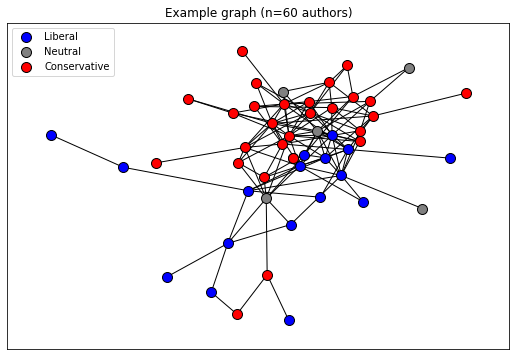

In [34]:
plt.figure(figsize=(9,6))

nodes = networkx.draw_networkx_nodes(lib_g, pos, nodelist=lib_g.nodes(), node_size = 100,
                                     node_color='blue', label='Liberal')#, cmap=plt.cm.Blues)
nodes.set_edgecolor('black')
nodes = networkx.draw_networkx_nodes(neut_g, pos, nodelist=neut_g.nodes(), node_size = 100,
                                     node_color='gray', label='Neutral')#, cmap=plt.cm.Blues)
nodes.set_edgecolor('black')
nodes = networkx.draw_networkx_nodes(cons_g, pos, nodelist=cons_g.nodes(), node_size = 100,
                                     node_color='red', label='Conservative')#, cmap=plt.cm.Blues)
nodes.set_edgecolor('black')
networkx.draw_networkx_edges(adj_graph, pos, node_size=100)
plt.title("Example graph (n=60 authors)")
plt.legend(loc='upper left')
plt.savefig('example_graph_50.png', bbox_inches='tight')